<a href="https://colab.research.google.com/github/Yashvishe13/Deep-Learning/blob/main/VGG2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/dataset/fruits-360-original-size/fruits-360-original-size/

/content/drive/My Drive/dataset/fruits-360-original-size/fruits-360-original-size


In [5]:
# Import libraries
from keras.layers import Dense, Input, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from glob import glob

In [6]:
# Image size
IMAGE_SIZE = [100, 100]
# training config
epochs = 5
batch_size = 32
train_path = 'Training'
valid_path = 'Validation'

In [7]:
# Getting files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [8]:
# Number of classes
folders = glob(train_path + '/*')

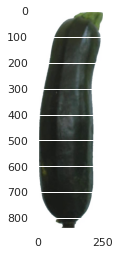

In [11]:
# plot image
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [13]:
# VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights = 'imagenet', include_top=False)

# don't train pre-existing weights
for layers in vgg.layers:
  layers.trainable = False

# Layers
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

# Model
model = Model(inputs=vgg.inputs, outputs=prediction)
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                              

In [14]:
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

Found 3114 images belonging to 24 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -115.09667 max: 151.061


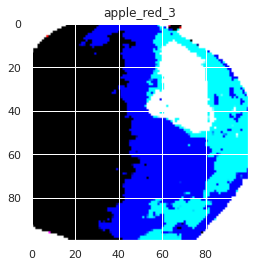

In [18]:
# Creating instance of ImageDataGenerator
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

for x, y in test_gen:
  print('min:', x[0].min(), 'max:', x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [19]:
# create generators
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size
)

valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size
)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.


In [21]:
# fit the model
r = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(valid_image_files) // batch_size
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/5
194/194 [==============================] - 1478s 8s/step - loss: 3.5920 - accuracy: 0.7692 - val_loss: 0.7064 - val_accuracy: 0.9220
Epoch 2/5
194/194 [==============================] - 94s 484ms/step - loss: 0.8523 - accuracy: 0.9243 - val_loss: 0.7980 - val_accuracy: 0.9372
Epoch 3/5
194/194 [==============================] - 94s 483ms/step - loss: 0.5702 - accuracy: 0.9468 - val_loss: 0.4695 - val_accuracy: 0.9607
Epoch 4/5
194/194 [==============================] - 94s 486ms/step - loss: 0.4637 - accuracy: 0.9590 - val_loss: 0.4329 - val_accuracy: 0.9617
Epoch 5/5
194/194 [==============================] - 94s 485ms/step - loss: 0.3364 - accuracy: 0.9693 - val_loss: 0.2327 - val_accuracy: 0.9803


In [23]:
# Confusion matrix
def get_confusion_matrix(data_path, N):
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 6231
Found 6231 images belonging to 24 classes.
50
[[306   0   0   0   0   1   0   5   2   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 302   0   0   0   0   0   0   7   3   6   0   2   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   1 305   0   0   0   1   0   9   0   2   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 308   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 305   2   0   1   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0  29 274  11   0   0   0   2   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   2 318   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 468   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 309   1   2   1   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   2   

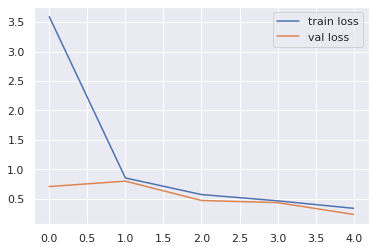

In [24]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

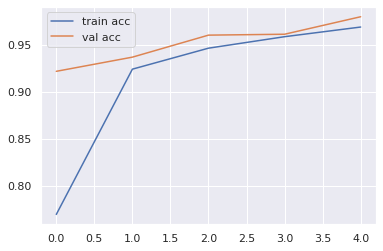

In [25]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

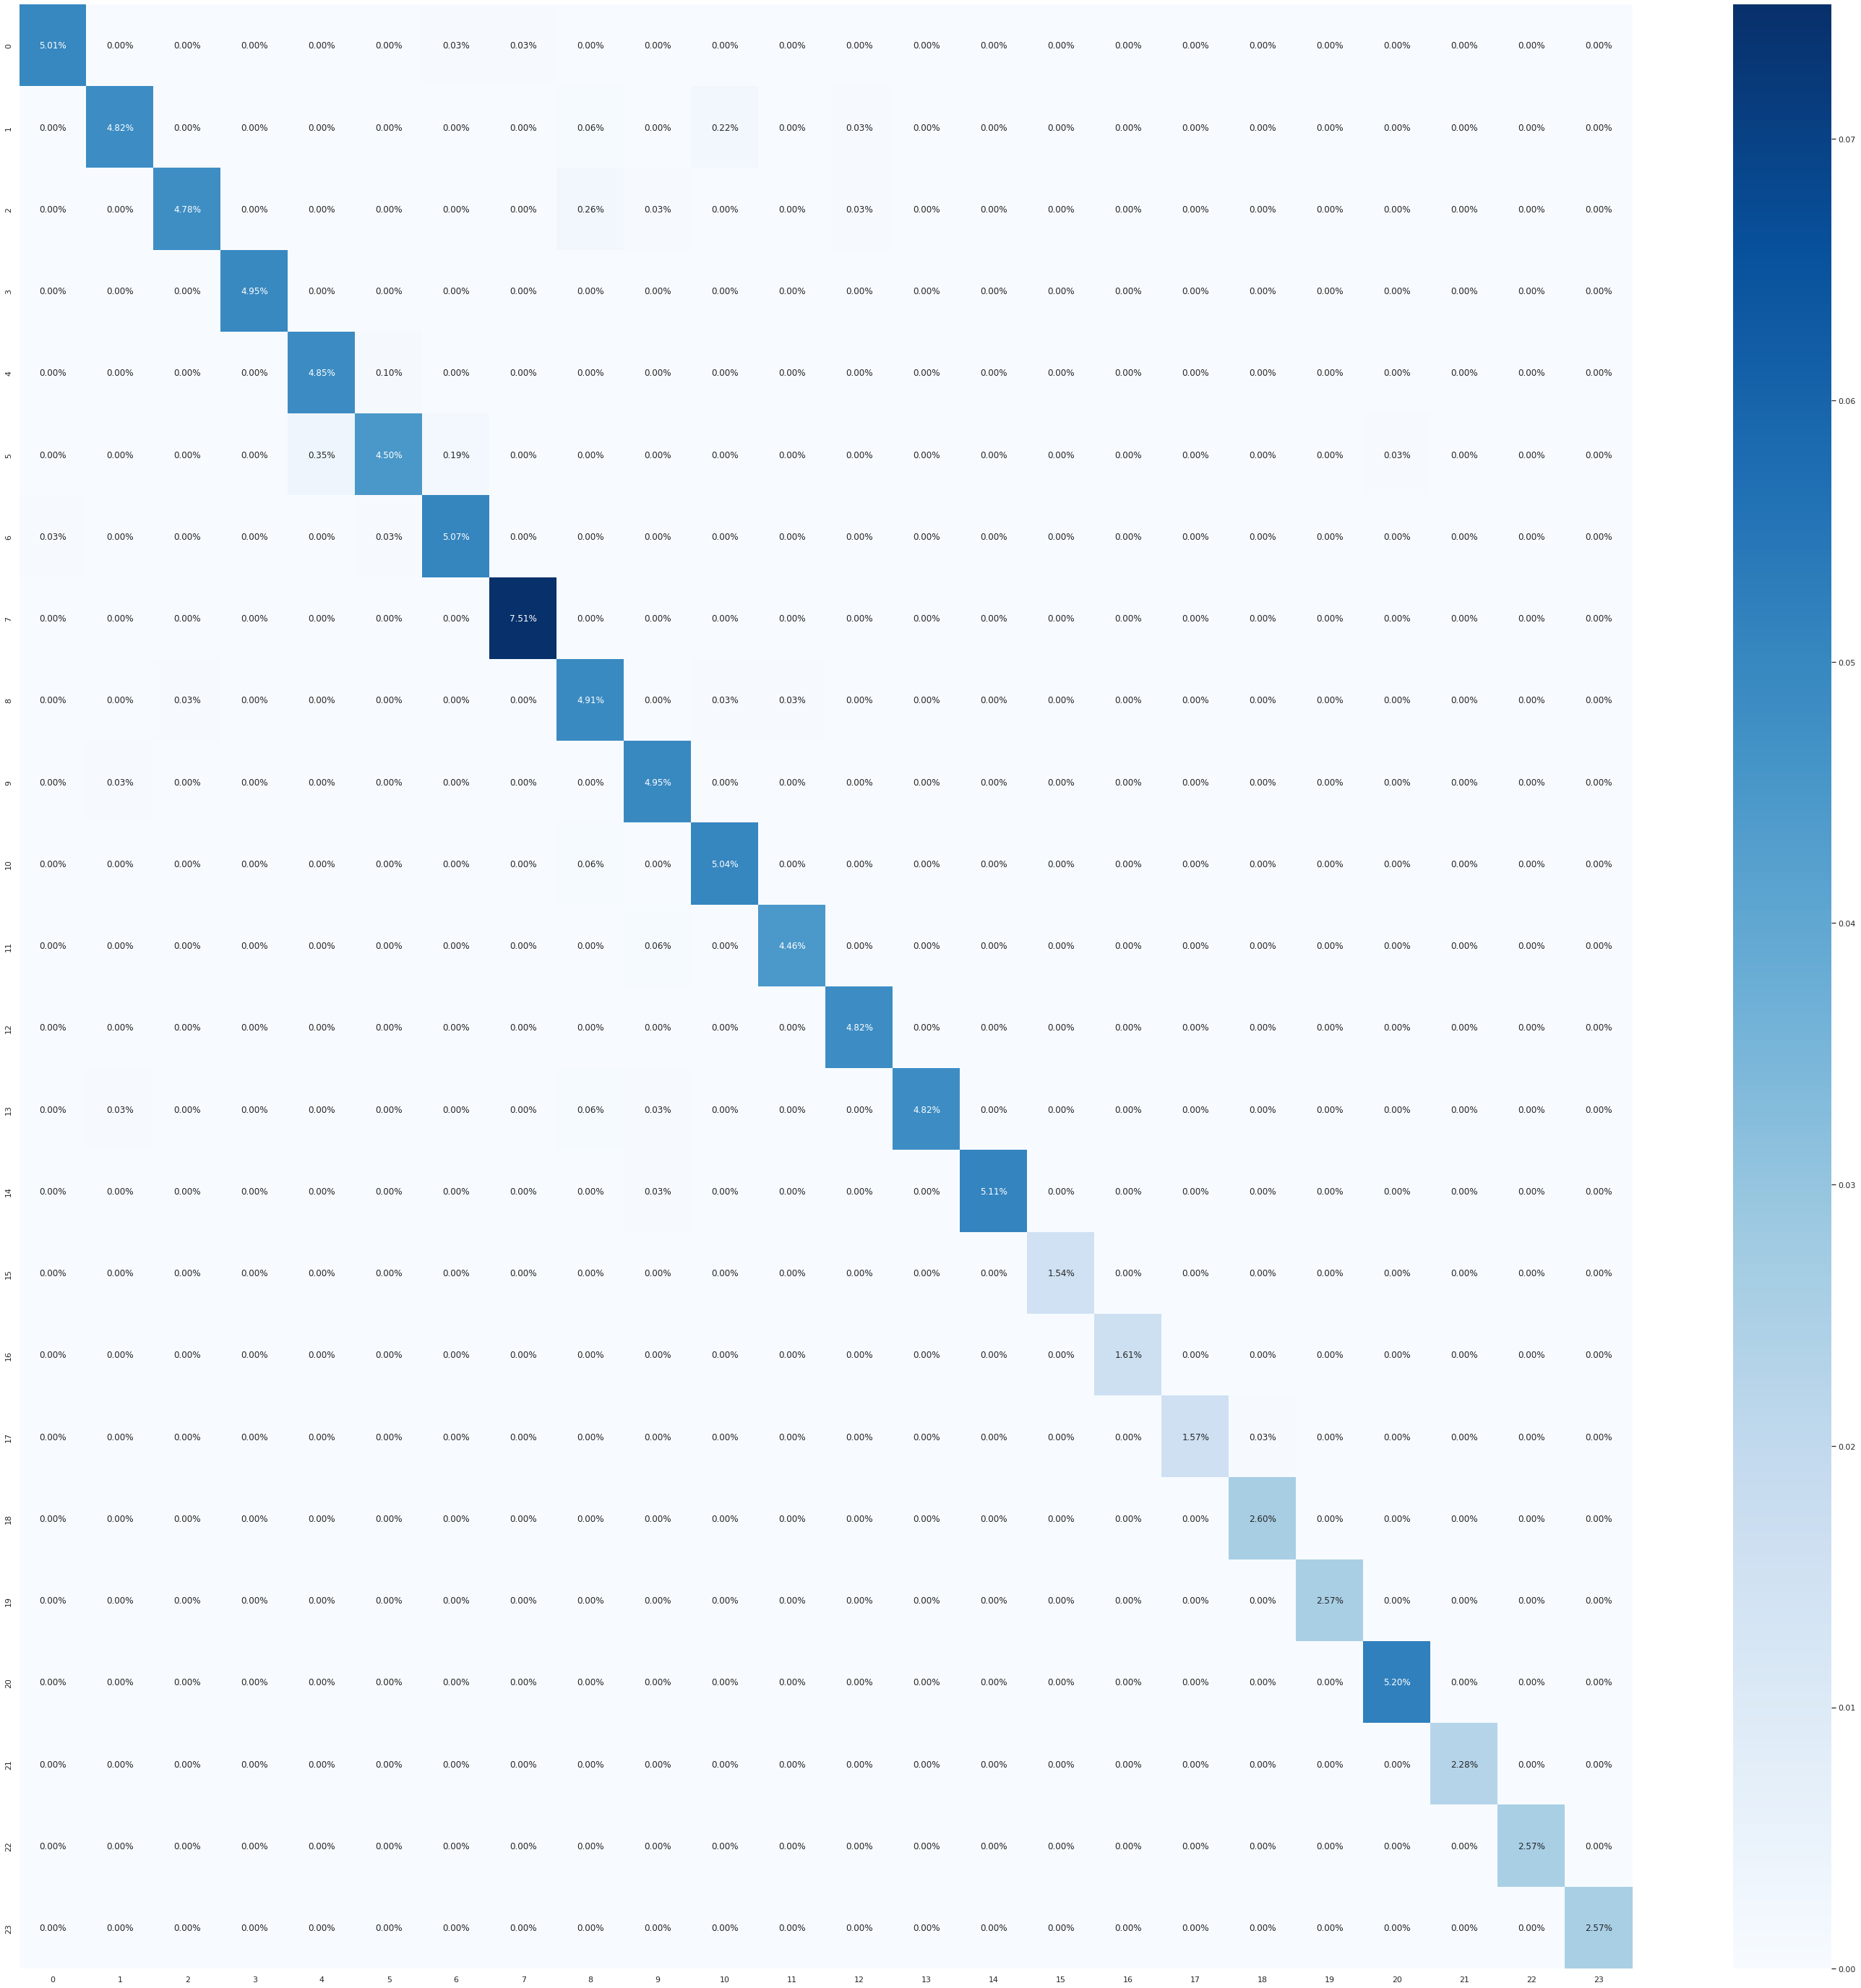

In [29]:
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(valid_cm/np.sum(valid_cm), annot=True, 
            fmt='.2%', cmap='Blues', ax=ax)